In [1]:
# Para gestionar ficheros
# -----------------------------------------------------------------------
import os
import glob

# Para trabajar con access porque realmente se tendría que hacer desde la terminal pero esto nos lo simula y por eso es mejor hacerlo por aquí porque lo simplifica
# -----------------------------------------------------------------------
import subprocess


# Para trabajar con DataFrames
# -----------------------------------------------------------------------
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Para trabajar con regex
# -----------------------------------------------------------------------
import re

# Para trabajar con ficheros
# -----------------------------------------------------------------------
import os


# Para trabajar con los DataFrames
# -----------------------------------------------------------------------
import pandas as pd

# Para poner barras progreso
# -----------------------------------------------------------------------
from tqdm import tqdm

from datetime import datetime
# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

from datetime import datetime
from dateutil.relativedelta import relativedelta

# Ignorar warings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_poblacional= pd.read_csv("datos/datos_descargados_INE_poblacion/03001.csv", encoding= 'latin-1', sep=';')
df_economico= pd.read_csv("datos/datos_descargados_INE_/67284.csv", encoding= 'latin-1', sep=';')

**Demanda Eléctrica:**

- **Conversión de Timestamps:** Asegúrate de que las fechas estén correctamente formateadas en `datetime`. Si es necesario, convierte los datos a un formato uniforme (por ejemplo, `YYYY-MM` para datos mensuales). ***DONE***

- **Tratamiento de Valores Nulos:** Identifica y maneja los valores nulos en caso de que los haya. Puedes optar por eliminar filas con valores faltantes. ***DONE***

- **Estandarización de Nombres de Provincias:** Verifica que los nombres de las provincias estén estandarizados y coincidan en todos los conjuntos de datos. Si hay inconsistencias, corrígelas. ***DONE***

INICIO LIMPIEZA Y CARGA DE DEMANDA (Esto es para leer, limpiar y juntar los datos de demanda)

In [3]:
ruta_origen= r"C:\Users\jaime\Desktop\Thepower\Día15\laboratorio-modulo5-leccion01-etl\datos\demanda"
df_todo_demanda= pd.DataFrame()
for ccaa in os.listdir(ruta_origen):
    df=pd.read_csv(f"datos\demanda\{ccaa}", index_col=0 )

    ruta_ccaa = os.path.join(ruta_origen, ccaa)
    nombreb= ccaa.split(".csv")
    nombre_anio=nombreb[0].split("_")
    nombre_ccaa= nombre_anio[0]

    df["ccaa"]=nombre_ccaa
    df_todo_demanda= pd.concat([df_todo_demanda,df], axis=0)


In [4]:
df_todo_demanda.reset_index(drop=True, inplace=True)

Quiero conseguir el formato correcto de fecha

In [5]:
df_todo_demanda["datetime"] = df_todo_demanda["datetime"].apply(lambda x: pd.to_datetime(x).strftime('%Y-%m'))

In [6]:
df_todo_demanda["month"] = df_todo_demanda["datetime"].apply(lambda x: pd.to_datetime(x).month)
df_todo_demanda["year"] = df_todo_demanda["datetime"].apply(lambda x: pd.to_datetime(x).year)

In [7]:
df_todo_demanda.drop(columns="datetime", inplace= True)

In [8]:
df_todo_demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       684 non-null    float64
 1   percentage  684 non-null    int64  
 2   cod_ccaa    684 non-null    int64  
 3   ccaa        684 non-null    object 
 4   month       684 non-null    int64  
 5   year        684 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.2+ KB


In [9]:
df_todo_demanda["ccaa"].unique()

array(['Andalucía', 'Aragón', 'Canarias', 'Cantabria',
       'Castilla - La Mancha', 'Castilla y León', 'Cataluña', 'Ceuta',
       'Comunidad de Madrid', 'Comunidad Foral de Navarra',
       'Comunitat Valenciana', 'Extremadura', 'Galicia', 'Illes Balears',
       'La Rioja', 'Melilla', 'País Vasco', 'Principado de Asturias',
       'Región de Murcia'], dtype=object)

In [10]:
df_todo_demanda["value"]

0      3668893.328
1      3152278.091
2      3216356.360
3      3029639.973
4      3154123.467
          ...     
679     901082.855
680     793300.950
681     707168.960
682     723781.406
683     781601.118
Name: value, Length: 684, dtype: float64

El value está en MWh

Esto se podrá utilizar en el futuro para meter los cods

In [11]:
cod_comunidades = {'Ceuta': 8744,
                        'Melilla': 8745,
                        'Andalucía': 4,
                        'Aragón': 5,
                        'Cantabria': 6,
                        'Castilla - La Mancha': 7,
                        'Castilla y León': 8,
                        'Cataluña': 9,
                        'País Vasco': 10,
                        'Principado de Asturias': 11,
                        'Comunidad de Madrid': 13,
                        'Comunidad Foral de Navarra': 14,
                        'Comunitat Valenciana': 15,
                        'Extremadura': 16,
                        'Galicia': 17,
                        'Illes Balears': 8743,
                        'Canarias': 8742,
                        'Región de Murcia': 21,
                        'La Rioja': 20}

FIN DE CREACION Y LIMPIEZA DE DEMANDA (FALTA NOMBRES COLUMNAS) y estaría bien poner el código de municipio para la futura creacion de BBDD

  - **Generación Eléctrica:**

    - **Desagregación de Tecnologías:** Asegúrate de que los datos estén correctamente desglosados por tipo de energía. Revisa que los campos correspondientes a energía eólica, solar, hidroeléctrica, etc., estén bien identificados y sin errores. ***DONE***

    - **Normalización de Unidades:** Verifica que las unidades de energía estén estandarizadas (por ejemplo, MWh). Realiza las conversiones necesarias si se encuentran en otras unidades. ***DONE***

    - **Identificación de Outliers:** Revisa los valores extremos o atípicos en la generación de energía y decide si deben ser tratados o eliminados. ***DONE***

INICIO DE CARGA Y LIMPIEZA DE OFERTA 

In [12]:
ruta_origen= r"C:\Users\jaime\Desktop\Thepower\Día15\laboratorio-modulo5-leccion01-etl\datos\oferta"
df_todo_oferta= pd.DataFrame()
for ccaa in os.listdir(ruta_origen):
    df=pd.read_csv(f"datos\oferta\{ccaa}", index_col=0 )

    ruta_ccaa = os.path.join(ruta_origen, ccaa)
    nombreb= ccaa.split(".csv")
    nombre_anio=nombreb[0].split("_")
    nombre_ccaa= nombre_anio[0]

    df["ccaa"]=nombre_ccaa
    df_todo_oferta= pd.concat([df_todo_oferta,df], axis=0)

In [13]:
df_todo_oferta.reset_index(drop=True, inplace=True)

Quiero conseguir el formato correcto de fecha

In [14]:
df_todo_oferta["datetime"] = df_todo_oferta["datetime"].apply(lambda x: pd.to_datetime(x).strftime('%Y-%m'))

In [15]:
df_todo_oferta["month"] = df_todo_oferta["datetime"].apply(lambda x: pd.to_datetime(x).month)
df_todo_oferta["year"] = df_todo_oferta["datetime"].apply(lambda x: pd.to_datetime(x).year)

In [16]:
df_todo_oferta.drop(columns="datetime", inplace= True)

In [17]:
df_todo_oferta.sample(4)

,value,percentage,type,cod_ccaa,ccaa,month,year
1329,310970.245,0.444192,Eólica,9,Cataluña,10,2020
1205,38616.282,0.027089,Otras renovables,8,Castilla y León,6,2021
2324,14955.211,0.005624,Residuos renovables,17,Galicia,12,2019
2185,572578.587,1.000000,Generación renovable,16,Extremadura,5,2020


Me he dado cuenta que nos da los totales metidos en Generación renovable asique lo elimino para que no afecte a medias etc

In [18]:
df_todo_oferta=df_todo_oferta[df_todo_oferta["type"]!= "Generación renovable"].reset_index(drop=True)

In [19]:
df_todo_oferta["type"].unique()

array(['Hidráulica', 'Eólica', 'Solar fotovoltaica', 'Solar térmica',
       'Otras renovables', 'Hidroeólica', 'Residuos renovables'],
      dtype=object)

In [20]:
df_todo_oferta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909 entries, 0 to 2908
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       2909 non-null   float64
 1   percentage  2909 non-null   float64
 2   type        2909 non-null   object 
 3   cod_ccaa    2909 non-null   int64  
 4   ccaa        2909 non-null   object 
 5   month       2909 non-null   int64  
 6   year        2909 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 159.2+ KB


El value está en MWh

In [21]:
df_todo_oferta.sample(4)

,value,percentage,type,cod_ccaa,ccaa,month,year
1635,50876.323,0.173946,Hidráulica,15,Comunitat Valenciana,5,2021
1874,196211.605,0.349711,Hidráulica,17,Galicia,6,2019
2262,85786.610,0.825287,Eólica,20,La Rioja,10,2020
2611,13.418,0.000047,Solar fotovoltaica,11,Principado de Asturias,3,2019


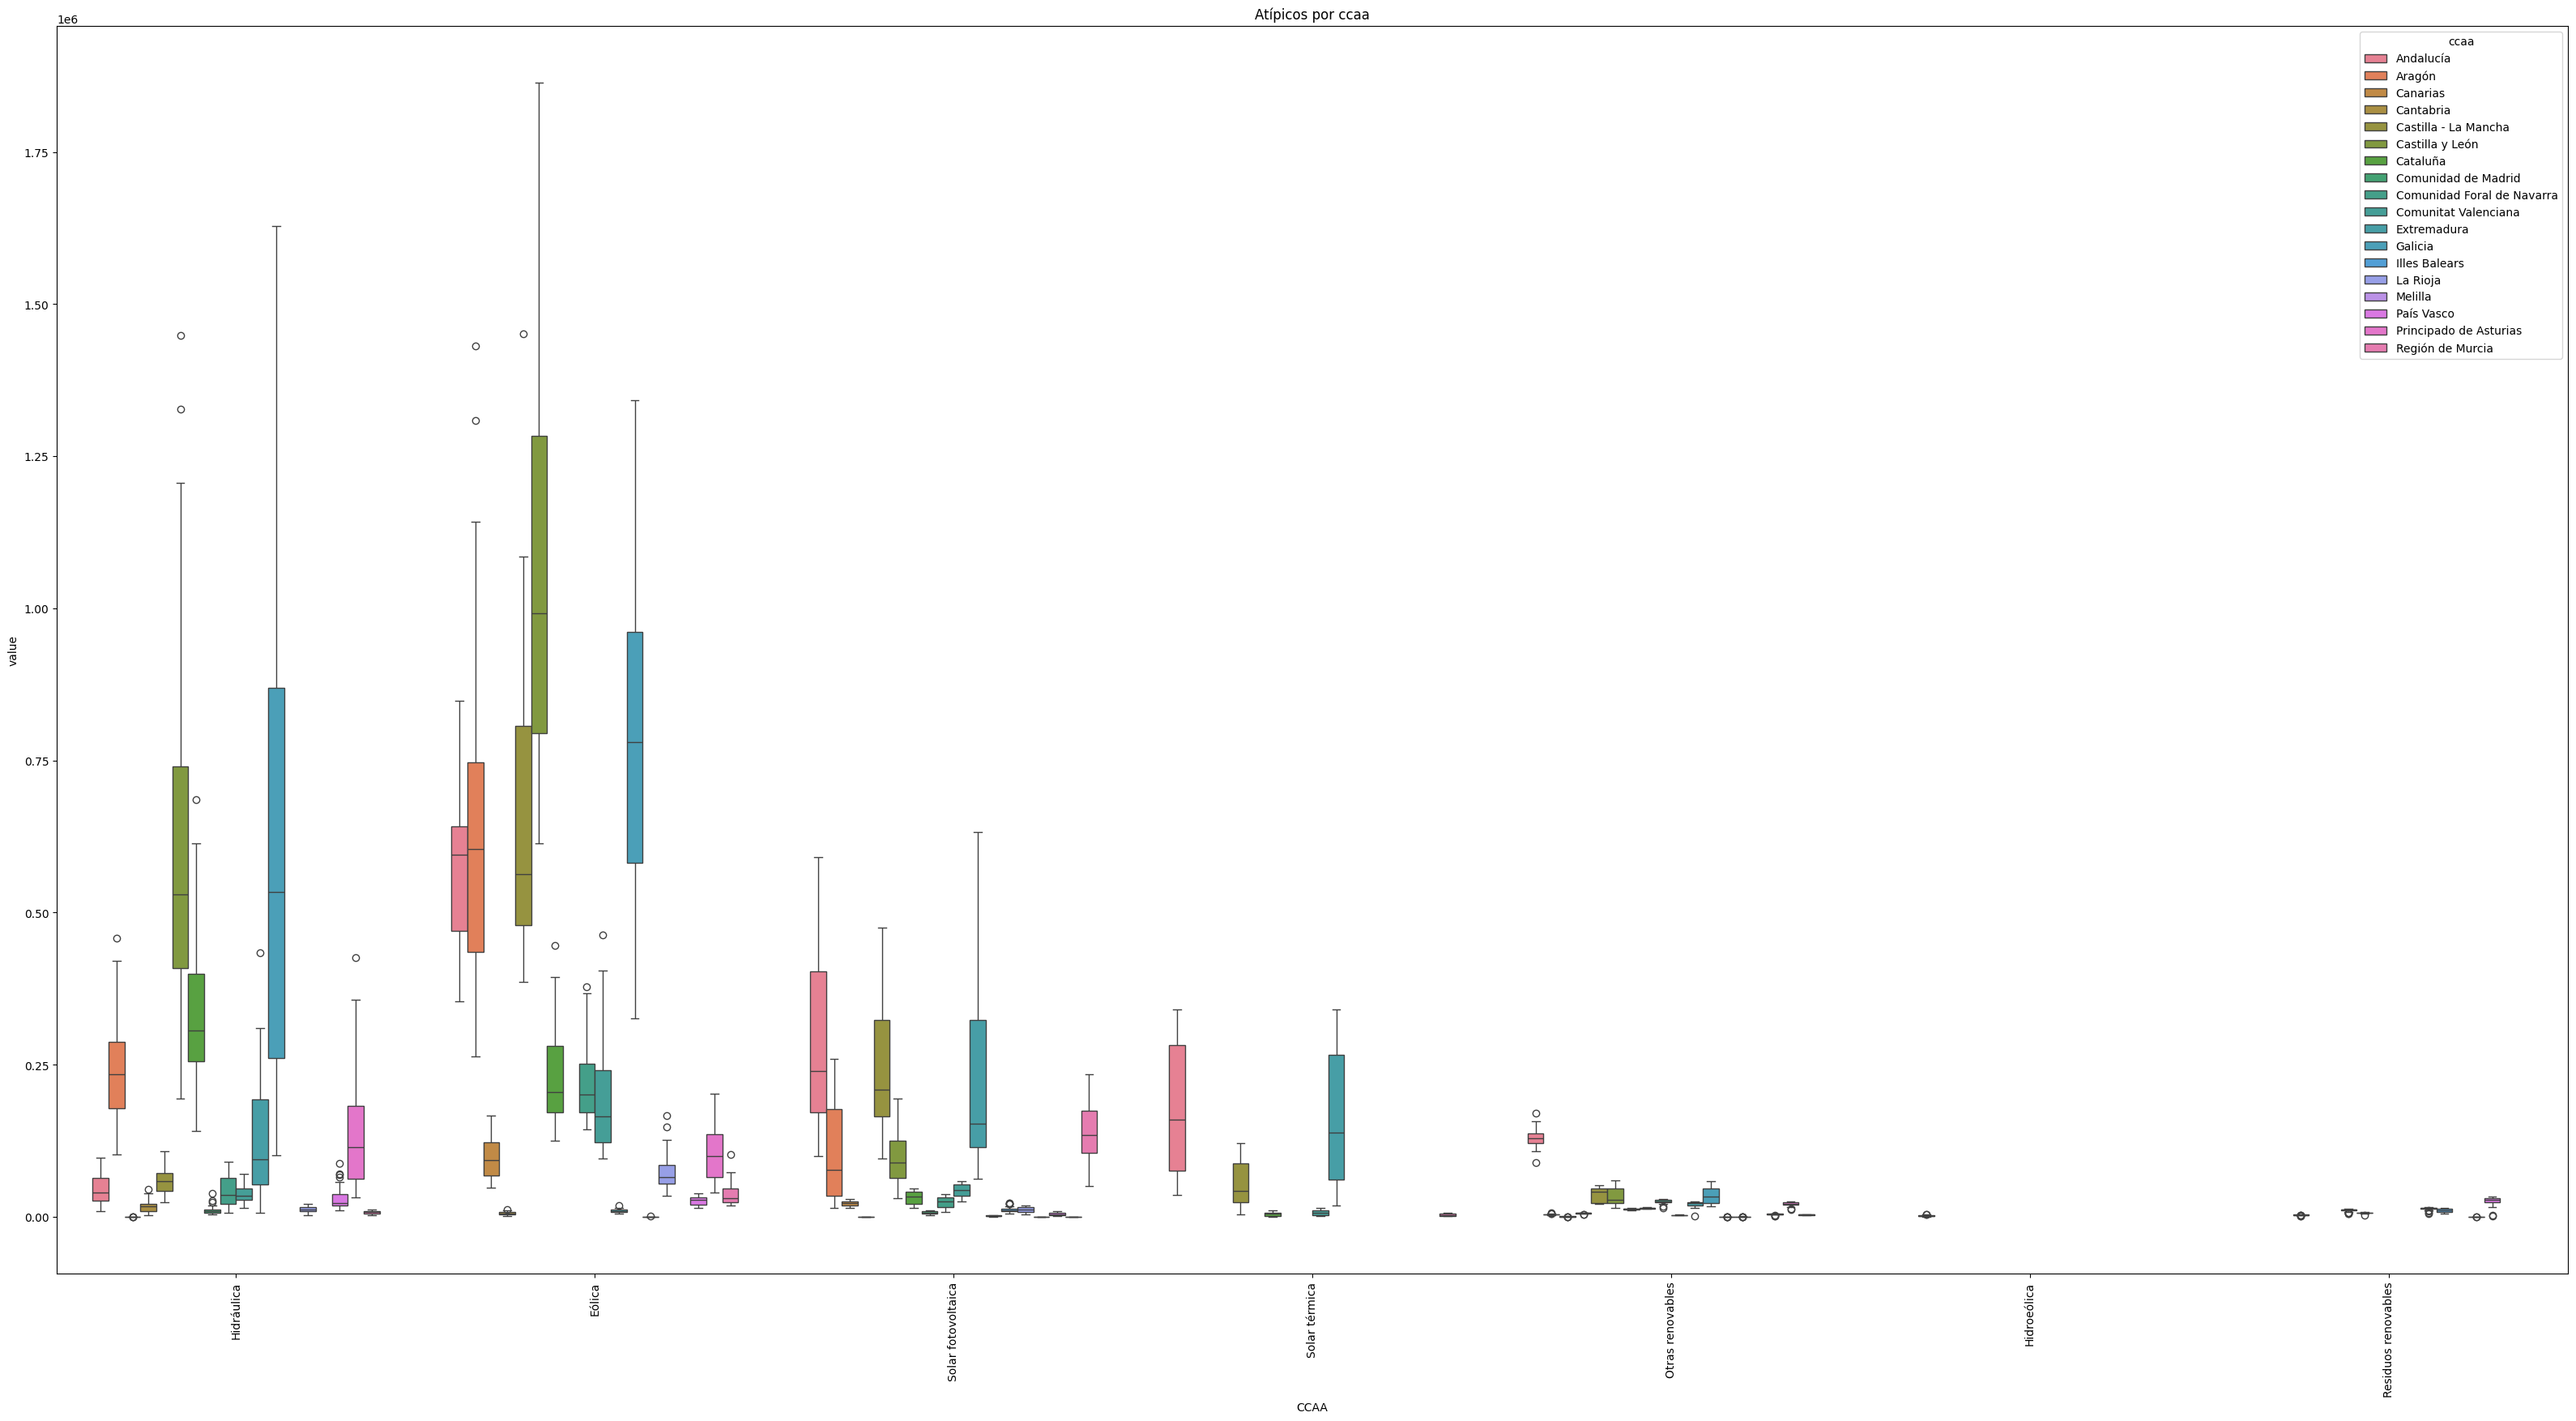

In [22]:
plt.figure(figsize=(40,20))
sns.boxplot(x="type" , y= "value", hue= "ccaa", data= df_todo_oferta )
plt.title("Atípicos por ccaa")
plt.xlabel("CCAA")
plt.xticks(rotation=90);

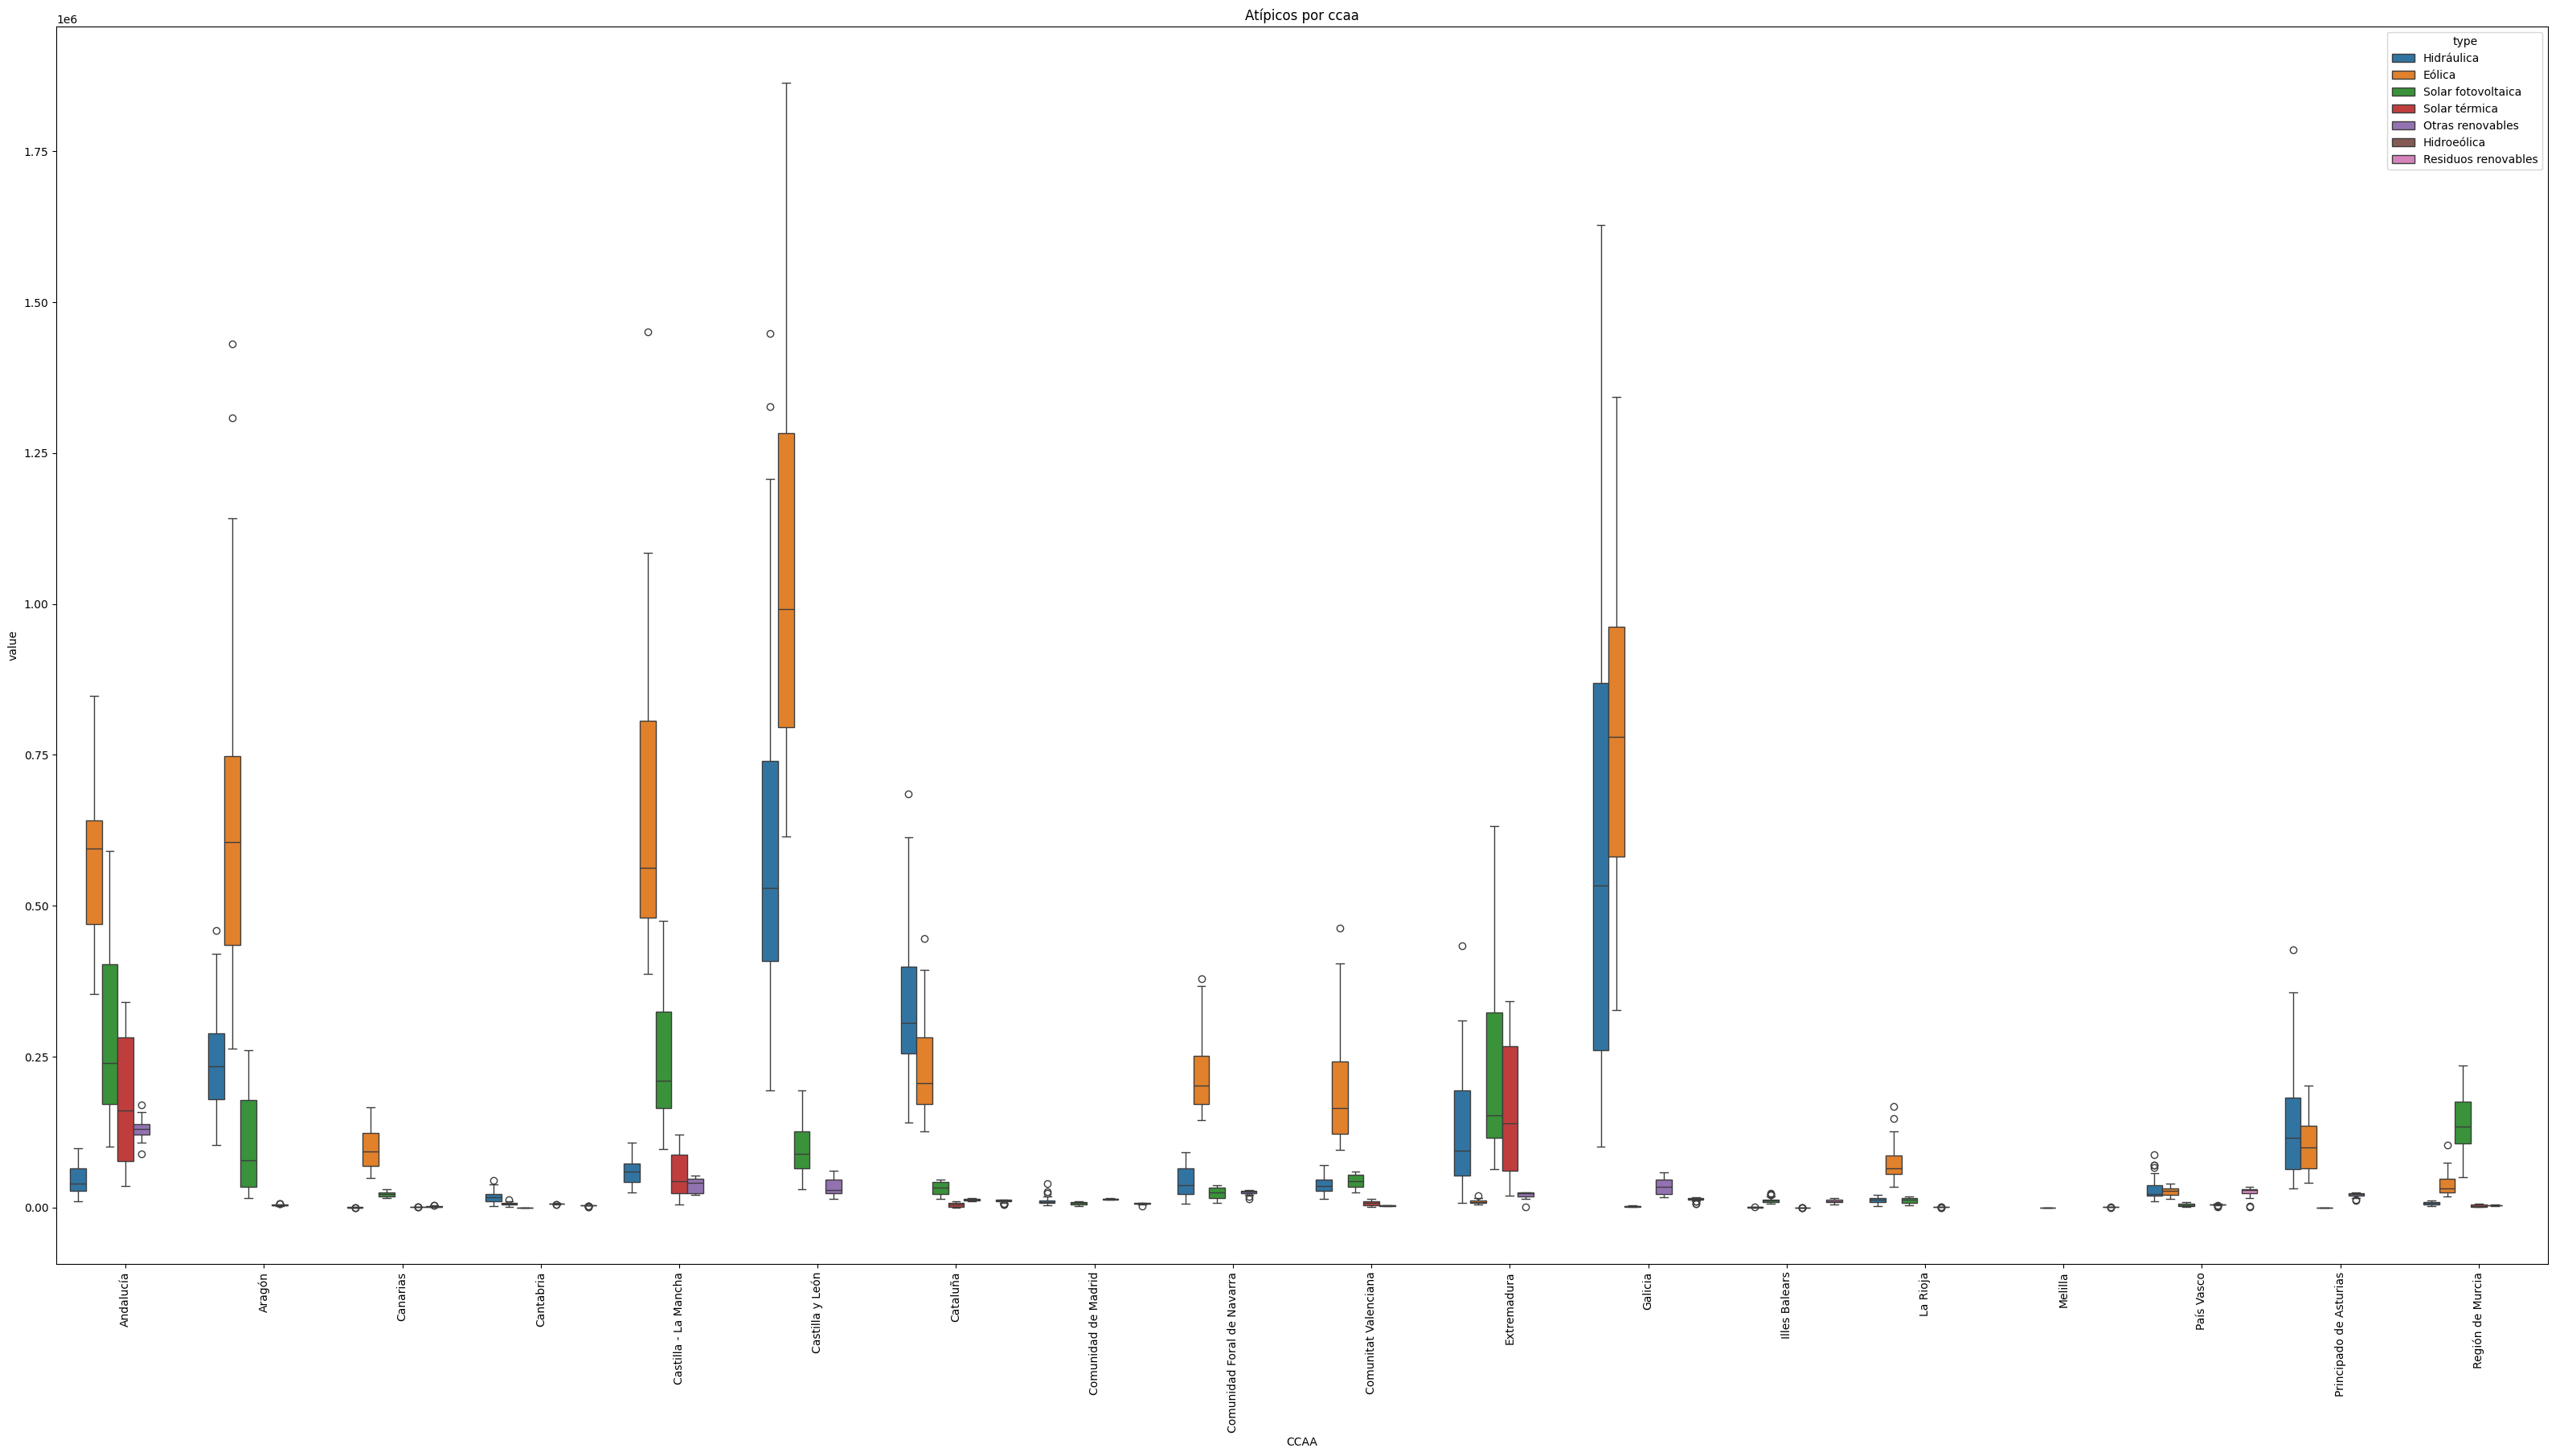

In [23]:
plt.figure(figsize=(40,20))
sns.boxplot(x="ccaa" , y= "value", hue= "type", data= df_todo_oferta )
plt.title("Atípicos por ccaa")
plt.xlabel("CCAA")
plt.xticks(rotation=90);

Esta funcion la he sacado de Chat

In [24]:

def detectar_outliers(df, columna_valor, columna_ccaa, columna_tipo):
    """
    Identifica outliers en cada comunidad autónoma y tipo de energía en el dataframe.
    
    Parámetros:
    - df: DataFrame con los datos
    - columna_valor: nombre de la columna con los valores numéricos (ej. 'value')
    - columna_ccaa: nombre de la columna con las comunidades autónomas (ej. 'ccaa')
    - columna_tipo: nombre de la columna con los tipos de energía (ej. 'type')
    
    Retorna:
    - DataFrame con los outliers y las columnas originales
    """
    outliers = []

    # Agrupa por comunidad autónoma y tipo de energía
    for (ccaa, tipo), grupo in df.groupby([columna_ccaa, columna_tipo]):
        Q1 = grupo[columna_valor].quantile(0.25)
        Q3 = grupo[columna_valor].quantile(0.75)
        IQR = Q3 - Q1

        # Define límites para detectar outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filtra los valores que son outliers
        outliers_grupo = grupo[(grupo[columna_valor] < lower_bound) | (grupo[columna_valor] > upper_bound)]
        
        # Añade los outliers al resultado
        outliers.append(outliers_grupo)

    # Combina todos los outliers en un solo DataFrame
    df_outliers = pd.concat(outliers)
    return df_outliers

df_outliers = detectar_outliers(df_todo_oferta, 'value', 'ccaa', 'type')

df_outliers.head()


,value,percentage,type,cod_ccaa,ccaa,month,year
52,88799.932,0.068701,Otras renovables,4,Andalucía,5,2019
179,170548.746,0.126362,Otras renovables,4,Andalucía,12,2021
288,1308593.598,0.820323,Eólica,5,Aragón,1,2021
298,1431317.856,0.866830,Eólica,5,Aragón,11,2021
232,458389.649,0.400711,Hidráulica,5,Aragón,5,2020


Estos son los que más atípicos tienen

In [25]:
df_outliers["ccaa"].value_counts()

ccaa
Illes Balears                 9
Cantabria                     9
País Vasco                    9
Canarias                      8
Cataluña                      7
Aragón                        6
La Rioja                      6
Galicia                       4
Comunidad de Madrid           4
Extremadura                   3
Comunidad Foral de Navarra    3
Principado de Asturias        3
Andalucía                     2
Castilla y León               2
Melilla                       2
Castilla - La Mancha          1
Comunitat Valenciana          1
Región de Murcia              1
Name: count, dtype: int64

Observamos que casualmente las ccaa que están en entornos montañosos, cercanos a la costa y de tamaño pequeño cuentan con más outliers

AQUÍ ACABA GENERACIÓN DE ENERGÍA 

  - **Datos Económicos:**

    - **Normalización del PIB:** Si los datos del PIB están en diferentes unidades o escalas, asegúrate de normalizarlos para que sean comparables entre provincias. ***DONE***

    - **Agrupación Temporal:** Si los datos económicos están disponibles en diferentes periodos temporales, agrúpalos y normalízalos para que coincidan con los datos eléctricos en términos de granularidad temporal (mensual o anual). ***DONE***

INICIO INE ECONOMICO

In [26]:
df_economico["Total"]=df_economico["Total"].str.replace(".", "").astype(int)
df_economico["periodo"]=df_economico["periodo"].str.replace("(P)", "").astype(int)

In [27]:
df_economico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716 entries, 0 to 1715
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Provincias          1716 non-null   object
 1   Ramas de actividad  1716 non-null   object
 2   periodo             1716 non-null   int64 
 3   Total               1716 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 53.8+ KB


In [28]:
df_economico=df_economico[df_economico["Ramas de actividad"]!= "PRODUCTO INTERIOR BRUTO A PRECIOS DE MERCADO"].reset_index(drop=True)
df_economico=df_economico[df_economico["Ramas de actividad"]!= "Valor añadido bruto total"].reset_index(drop=True)
df_economico=df_economico[df_economico["Ramas de actividad"]!= "Impuestos netos sobre los productos"].reset_index(drop=True)

In [29]:
df_economico["Ramas de actividad"].unique()

array(['A. Agricultura, ganadería, silvicultura y pesca',
       'B_E. Industrias extractivas, industria manufacturera, suministro de energía eléctrica, gas, vapor y aire acondicionado, suministro de agua, actividades de saneamiento, gestión de residuos y descontaminación',
       'C. - De las cuales: Industria manufacturera', 'F. Construcción',
       'G_J. Comercio al por mayor y al por menor, reparación de vehículos de motor y motocicletas, transporte y almacenamiento, hostelería, información y comunicaciones',
       'K_N. Actividades financieras y de seguros, actividades inmobiliarias, actividades profesionales, científicas y técnicas, actividades administrativas y servicios auxiliares',
       'O_U. Administración pública y defensa, seguridad social obligatoria, educación, actividades sanitarias y de servicios sociales, actividades artísticas, recreativas y de entretenimiento, reparación de artículos de uso doméstico y otros servicios'],
      dtype=object)

Quiero sacar el codigo de provincia y el codigo de ramas de actividad

In [30]:
df_economico[["cod_prov", "provincias"]]= df_economico["Provincias"].str.split(" ", n=1, expand=True)
df_economico[["cod_actividad", "ramas de actividad"]]= df_economico["Ramas de actividad"].str.split(".", n=1, expand=True)


In [31]:
df_economico.drop(columns="Provincias", inplace= True)
df_economico.drop(columns="Ramas de actividad", inplace= True)

In [32]:
df_economico["cod_actividad"]=df_economico["cod_actividad"].str.replace("A", "1")   
df_economico["cod_actividad"]=df_economico["cod_actividad"].str.replace("B_E", "2")
df_economico["cod_actividad"]=df_economico["cod_actividad"].str.replace("C", "3")
df_economico["cod_actividad"]=df_economico["cod_actividad"].str.replace("G_J", "4")
df_economico["cod_actividad"]=df_economico["cod_actividad"].str.replace("K_N", "5")
df_economico["cod_actividad"]=df_economico["cod_actividad"].str.replace("O_U", "6")
df_economico["cod_actividad"]=df_economico["cod_actividad"].str.replace("F", "7")


In [33]:
df_economico["cod_actividad"]=df_economico["cod_actividad"].astype(int)
df_economico["cod_prov"]=df_economico["cod_prov"].astype(int)
df_economico["cod_actividad"].unique()

array([1, 2, 3, 7, 4, 5, 6])

In [34]:
df_economico.sample(5)

,periodo,Total,cod_prov,provincias,cod_actividad,ramas de actividad
651,2021,1555680,30,Murcia,1,"Agricultura, ganadería, silvicultura y pesca"
297,2021,5233733,12,Castellón/Castelló,2,"Industrias extractivas, industria manufacture..."
329,2019,2097107,13,Ciudad Real,4,"Comercio al por mayor y al por menor, reparac..."
893,2019,150055,42,Soria,7,Construcción
141,2021,2390063,6,Badajoz,5,"Actividades financieras y de seguros, activid..."


In [35]:
df_economico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   periodo             1092 non-null   int64 
 1   Total               1092 non-null   int64 
 2   cod_prov            1092 non-null   int64 
 3   provincias          1092 non-null   object
 4   cod_actividad       1092 non-null   int64 
 5   ramas de actividad  1092 non-null   object
dtypes: int64(4), object(2)
memory usage: 51.3+ KB


FIN DE INE ECONOMICA

  - **Datos Demográficos:**

    - **Consistencia en la Codificación de Provincias:** Asegúrate de que los nombres de las provincias en los datos demográficos coincidan con los nombres utilizados en los datos eléctricos.  ***DONE?***(Como unos son municipios y otros son municipios no tienen sentido(En un futuro se agruparán))

    - **Revisión de Categorías:** Verifica que las categorías de edad, sexo, y nacionalidad estén correctamente etiquetadas y sean consistentes en todo el dataset.***DONE***

    - **Manejo de Valores Faltantes:** Revisa la presencia de valores faltantes y decide cómo tratarlos (relleno, eliminación o sustitución). ***DONE***

INICIO INE POBLACIONAL

In [36]:
df_poblacional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7632 entries, 0 to 7631
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Provincias               7632 non-null   object
 1   Edad (3 grupos de edad)  7632 non-null   object
 2   Españoles/Extranjeros    7632 non-null   object
 3   Sexo                     7632 non-null   object
 4   Año                      7632 non-null   int64 
 5   Total                    7632 non-null   object
dtypes: int64(1), object(5)
memory usage: 357.9+ KB


In [37]:
df_poblacional=df_poblacional[df_poblacional["Provincias"]!= "TOTAL ESPAÑA"].reset_index(drop=True)
df_poblacional=df_poblacional[df_poblacional["Edad (3 grupos de edad)"]!= "TOTAL EDADES"].reset_index(drop=True)
df_poblacional=df_poblacional[df_poblacional["Españoles/Extranjeros"]!= "TOTAL"].reset_index(drop=True)
df_poblacional=df_poblacional[df_poblacional["Sexo"]!= "Ambos sexos"].reset_index(drop=True)
df_poblacional=df_poblacional[df_poblacional["Españoles/Extranjeros"]!= f"% Extranjeros"].reset_index(drop=True)

In [38]:
df_poblacional[["cod_prov", "provincias"]]= df_poblacional["Provincias"].str.split(" ", n=1, expand=True)
df_poblacional.drop(columns="Provincias", inplace= True)

In [39]:
df_poblacional["Total"]

0       27.304
1       27.979
2       28.513
3       25.547
4       25.953
         ...  
1867       447
1868       422
1869       489
1870       486
1871       443
Name: Total, Length: 1872, dtype: object

In [40]:
df_poblacional["cod_prov"]=df_poblacional["cod_prov"].astype(int)
df_poblacional["Total"]=df_poblacional["Total"].str.replace(".","")
df_poblacional["Total"]=df_poblacional["Total"].str.replace(",",".")
df_poblacional["Total"]=df_poblacional["Total"].astype(float)

In [42]:
df_poblacional.head()

,Edad (3 grupos de edad),Españoles/Extranjeros,Sexo,Año,Total,cod_prov,provincias
0,0-15 años,Españoles,Hombres,2021,27304.0,2,Albacete
1,0-15 años,Españoles,Hombres,2020,27979.0,2,Albacete
2,0-15 años,Españoles,Hombres,2019,28513.0,2,Albacete
3,0-15 años,Españoles,Mujeres,2021,25547.0,2,Albacete
4,0-15 años,Españoles,Mujeres,2020,25953.0,2,Albacete


In [43]:
df_poblacional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Edad (3 grupos de edad)  1872 non-null   object 
 1   Españoles/Extranjeros    1872 non-null   object 
 2   Sexo                     1872 non-null   object 
 3   Año                      1872 non-null   int64  
 4   Total                    1872 non-null   float64
 5   cod_prov                 1872 non-null   int64  
 6   provincias               1872 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 102.5+ KB


In [44]:
df_poblacional["provincias"].unique()

array(['Albacete', 'Alicante/Alacant', 'Almería', 'Araba/Álava',
       'Asturias', 'Ávila', 'Badajoz', 'Balears, Illes', 'Barcelona',
       'Bizkaia', 'Burgos', 'Cáceres', 'Cádiz', 'Cantabria',
       'Castellón/Castelló', 'Ciudad Real', 'Córdoba', 'Coruña, A',
       'Cuenca', 'Gipuzkoa', 'Girona', 'Granada', 'Guadalajara', 'Huelva',
       'Huesca', 'Jaén', 'León', 'Lleida', 'Lugo', 'Madrid', 'Málaga',
       'Murcia', 'Navarra', 'Ourense', 'Palencia', 'Palmas, Las',
       'Pontevedra', 'Rioja, La', 'Salamanca', 'Santa Cruz de Tenerife',
       'Segovia', 'Sevilla', 'Soria', 'Tarragona', 'Teruel', 'Toledo',
       'Valencia/València', 'Valladolid', 'Zamora', 'Zaragoza', 'Ceuta',
       'Melilla'], dtype=object)

diccionario para mapear las provincias en sus comunidades autónomas (Creo que no lo usaré)

In [45]:
provincias_comunidades = {
    'Albacete': 7,  # Castilla - La Mancha
    'Alicante/Alacant': 15,  # Comunitat Valenciana
    'Almería': 4,  # Andalucía
    'Araba/Álava': 10,  # País Vasco
    'Asturias': 11,  # Principado de Asturias
    'Ávila': 8,  # Castilla y León
    'Badajoz': 16,  # Extremadura
    'Balears, Illes': 8743,  # Illes Balears
    'Barcelona': 9,  # Cataluña
    'Bizkaia': 10,  # País Vasco
    'Burgos': 8,  # Castilla y León
    'Cáceres': 16,  # Extremadura
    'Cádiz': 4,  # Andalucía
    'Cantabria': 6,  # Cantabria
    'Castellón/Castelló': 15,  # Comunitat Valenciana
    'Ciudad Real': 7,  # Castilla - La Mancha (Ciudad Real)
    'Córdoba': 4,  # Andalucía
    'Coruña, A': 17,  # Galicia
    'Cuenca': 7,  # Castilla - La Mancha
    'Gipuzkoa': 10,  # País Vasco
    'Girona': 9,  # Cataluña
    'Granada': 4,  # Andalucía
    'Guadalajara': 7,  # Castilla - La Mancha
    'Huelva': 4,  # Andalucía
    'Huesca': 5,  # Aragón
    'Jaén': 4,  # Andalucía
    'León': 8,  # Castilla y León
    'Lleida': 9,  # Cataluña
    'Lugo': 17,  # Galicia
    'Madrid': 13,  # Comunidad de Madrid
    'Málaga': 4,  # Andalucía
    'Murcia': 21,  # Región de Murcia
    'Navarra': 14,  # Comunidad Foral de Navarra
    'Ourense': 17,  # Galicia
    'Palencia': 8,  # Castilla y León
    'Palmas, Las': 8742,  # Canarias (Las Palmas)
    'Pontevedra': 17,  # Galicia
    'Rioja, La': 20,  # La Rioja
    'Salamanca': 8,  # Castilla y León
    'Santa Cruz de Tenerife': 8742,  # Canarias (Santa Cruz de Tenerife)
    'Segovia': 8,  # Castilla y León
    'Sevilla': 4,  # Andalucía
    'Soria': 8,  # Castilla y León
    'Tarragona': 9,  # Cataluña
    'Teruel': 5,  # Aragón
    'Toledo': 7,  # Castilla - La Mancha
    'Valencia/València': 15,  # Comunitat Valenciana
    'Valladolid': 8,  # Castilla y León
    'Zamora': 8,  # Castilla y León
    'Zaragoza': 5,  # Aragón
    'Ceuta': 8744,  # Ceuta
    'Melilla': 8745   # Melilla
}

FIN INE POBLACIONAL